<a href="https://colab.research.google.com/github/Sergrey5571/Sergrey5571/blob/main/%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B_Light.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание и загрузка библиотек.

Работа осуществляется с базой акции лукойла.

1. Обучите простую полносвязную сеть для прогнозирования временного ряда. Используйте только столбец close и визуализируйте результат.

2. Обучите такую же архитектуру сети на прогнозирование на 10 шагов вперёд прямым способом и визуализируйте результат.

3. Постройте графики сравнения предсказания с оригинальным сигналом по всем 10 шагам предсказания (10 графиков на разных отдельных осях).

4. Сделайте те же задания с другой сетью, которая будет использовать Conv1D или LSTM слой

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalAveragePooling1D, MaxPooling1D, RepeatVector
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
base_data = pd.read_csv('/content/drive/MyDrive/БАЗЫ/18_19.csv', sep=';')


Mounted at /content/drive


In [ ]:
base_data[:3]


,DATE,TIME,OPEN,MAX,MIN,CLOSE,VOLUME
0,03.01.2018,10:00:00,3341.0,3356.0,3340.0,3355.0,6088
1,03.01.2018,10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2,03.01.2018,10:02:00,3351.5,3357.5,3351.5,3357.5,722


In [ ]:
data = base_data.drop(columns=['DATE', 'TIME'])# новая версия базового блока


In [ ]:
data[:3]

,OPEN,MAX,MIN,CLOSE,VOLUME
0,3341.0,3356.0,3340.0,3355.0,6088
1,3355.0,3359.0,3353.0,3353.0,1624
2,3351.5,3357.5,3351.5,3357.5,722


In [ ]:
data = np.array(data)

In [ ]:
data.shape

(217947, 5)

# пункт 1. Простая Dense сеть

In [ ]:
chanelNames = ['Open', 'Max', 'Min', 'Close', 'Volume']

In [ ]:
xLen = 300
valLen = 20000 #проверочная
trainLen = data.shape[0] - valLen # из всей базы вычитаю проверочную, вот и получается тренировочная

xTrain, xTest = data[:trainLen], data[trainLen+xLen +2:]


Для Х, Y:

In [ ]:
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

yTrain, yTest = np.reshape(data[:trainLen, 3],(-1,1)), np.reshape(data[trainLen+xLen + 2:, 3], (-1,1))
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
yTrain = yScaler.transform(yTrain)
yTest = yScaler.transform(yTest)

генератор:

In [ ]:
testDataGen = TimeseriesGenerator(xTest, yTest, length=xLen, batch_size=40) # stride = 1, не указываю, значение стоит по умолчанию
trainDataGen = TimeseriesGenerator(xTrain, yTrain, length=xLen, batch_size=40)

In [ ]:
print(trainDataGen[0][0].shape, trainDataGen[0][1].shape)

(40, 300, 5) (40, 1)


# Функции

In [ ]:
def getPred(currModel, xVal, yVal, yScaler):
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  return (predVal, yValUnscaled)

In [ ]:
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.figure(figsize=(20,7))
  plt.plot(predVal[start:start+step,0], label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], label='Базовый ряд')
  plt.xlabel('Time')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

In [ ]:
def corellate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()

  val = 1
  if ((sa>0)&(sb>0)):# чтобы не делить на ноль
    val = (mab-ma*mb)/(sa*sb)
  return val

In [ ]:
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  for ch in channels:
    corr = [] #  пустой лист
    yLen = yValUnscaled.shape[0] 
    for i in range(corrSteps):
      corr.append(corellate(yValUnscaled[:yLen-i,ch], predVal[i:,0]))
    own_corr = [] 
    for i in range(corrSteps):
      own_corr.append(corellate(yValUnscaled[:yLen-i,ch], yValUnscaled[i:, ch]))
    plt.figure(figsize=(14,7))
    plt.plot(corr, label='Предсказание на ' + str(ch+1) + ' шаг')
    plt.plot(own_corr, label='Эталон')
  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

генератор проверочной выборки

In [ ]:
DataGen = TimeseriesGenerator(xTest, yTest, length=300, batch_size=len(xTest))
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])
xVal = np.array(xVal)
yVal = np.array(yVal)

In [ ]:
modelD = Sequential()
modelD.add(Dense(128, input_shape = (xLen,5), activation='relu'))
modelD.add(Flatten())
modelD.add(Dense(1, activation='linear'))
modelD.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))
modelD.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300, 128)          768       
                                                                 
 flatten (Flatten)           (None, 38400)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 38401     
                                                                 
Total params: 39,169
Trainable params: 39,169
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = modelD.fit(trainDataGen, epochs=30, verbose=1, validation_data=testDataGen)

Epoch 1/30
4942/4942 [==============================] - 15s 3ms/step - loss: 0.0014 - val_loss: 5.1067e-04
Epoch 2/30
4942/4942 [==============================] - 13s 3ms/step - loss: 5.4416e-04 - val_loss: 0.0031
Epoch 3/30
4942/4942 [==============================] - 13s 3ms/step - loss: 3.1398e-04 - val_loss: 5.8258e-05
Epoch 4/30
4942/4942 [==============================] - 13s 3ms/step - loss: 1.5308e-04 - val_loss: 6.1745e-05
Epoch 5/30
4942/4942 [==============================] - 13s 3ms/step - loss: 1.3422e-04 - val_loss: 5.6610e-05
Epoch 6/30
4942/4942 [==============================] - 13s 3ms/step - loss: 1.0344e-04 - val_loss: 2.7157e-05
Epoch 7/30
4942/4942 [==============================] - 13s 3ms/step - loss: 7.8189e-05 - val_loss: 4.8845e-05
Epoch 8/30
4942/4942 [==============================] - 13s 3ms/step - loss: 7.6566e-05 - val_loss: 3.2529e-05
Epoch 9/30
4942/4942 [==============================] - 13s 3ms/step - loss: 6.3836e-05 - val_loss: 8.4147e-05
Epoch 10/

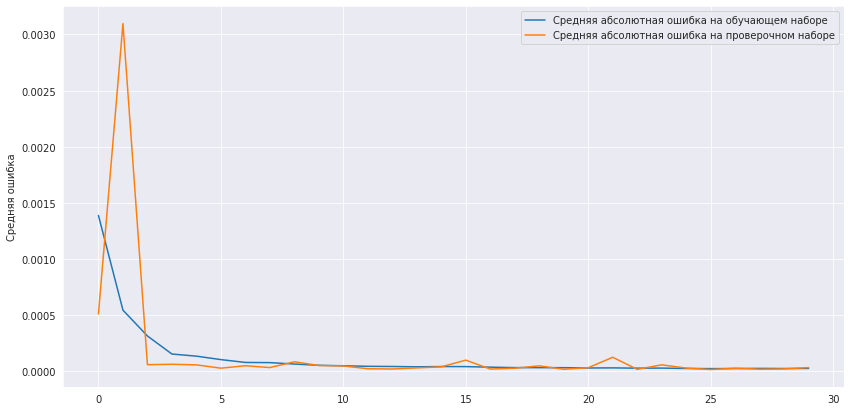

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

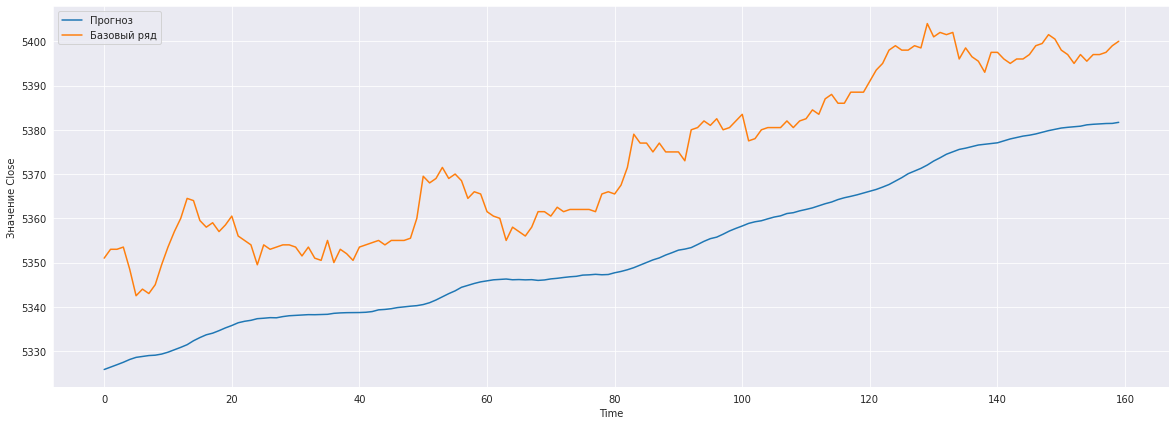

In [ ]:
currModel = modelD #Выбираем текущую модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) #Прогнозируем данные

showPredict(0, 160, 0, predVal, yValUnscaled)

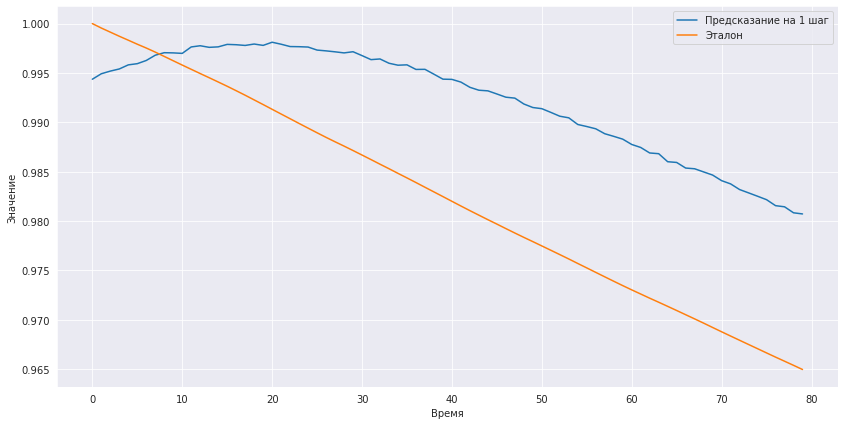

In [ ]:
showCorr([0], 80, predVal, yValUnscaled)

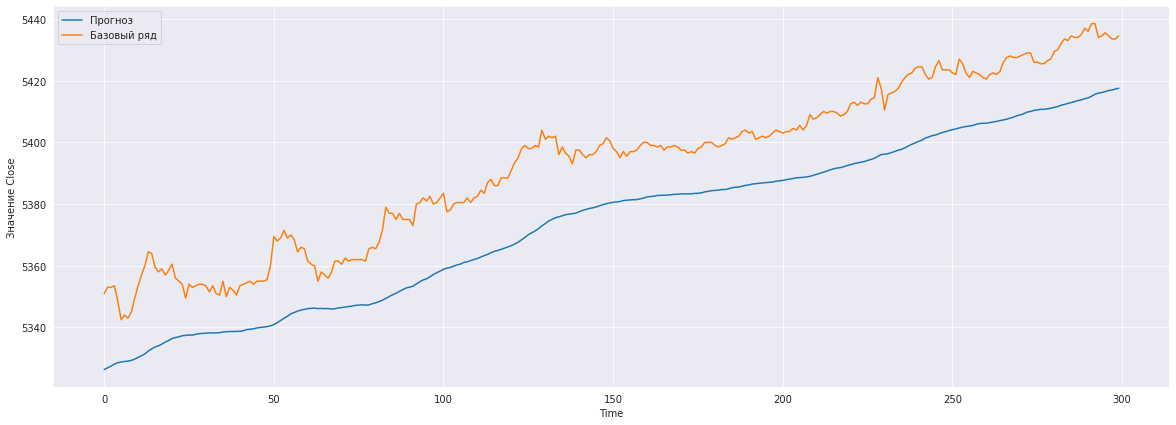

In [ ]:
currModel = modelD # текущaя модель
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) 

showPredict(0, 300, 0, predVal[1:], yValUnscaled[:-1])

# пункт 2. 10 шагов вперёд.

In [ ]:
xLen = 300
valLen = 20000 #проверочная
trainLen = data.shape[0] - valLen # из всей базы вычитаю проверочную, вот и получается тренировочная

xTrain, xTest = data[:trainLen-10], data[trainLen+xLen +2:-10]

In [ ]:
xScaler = MinMaxScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)
yTrain, yTest = (np.array([data[:trainLen, 3][i:i+10] for i in range(len(data[:trainLen, 3])-10)]), 
                 np.array([data[trainLen+xLen + 2:, 3][i:i+10] for i in range(len(data[trainLen+xLen + 2:, 3])-10)]))
#yTrain, yTest = np.array([data[:trainLen, 3][i:i+10] for i in range(len(data[:trainLen, 3])-10)]), np.array(data[trainLen+xLen + 2:, 3])
yScaler = MinMaxScaler()
yScaler.fit(yTrain)
#yTrain = yScaler.transform(yTrain)
#yTest = yScaler.transform(yTest)

MinMaxScaler()

In [ ]:
#print(yTrain)
print(yTrain.shape)
print(yTest.shape)
print(xTrain.shape)
print(xTest.shape)


(197937, 10)
(19688, 10)
(197937, 5)
(19688, 5)


In [ ]:
DataGen = TimeseriesGenerator(xTest, yTest, length=300, batch_size=len(xTest))
xVal = []
yVal = []
for i in DataGen:
  xVal.append(i[0])
  yVal.append(i[1])
xVal = np.array(xVal)
yVal = np.array(yVal)

In [ ]:
print(xVal.shape)
print(yVal.shape)

(1, 19388, 300, 5)
(1, 19388, 10)


In [ ]:
testDataGen10 = TimeseriesGenerator(xTest, yTest, length=xLen, batch_size=40) 
trainDataGen10 = TimeseriesGenerator(xTrain, yTrain, length=xLen, batch_size=40)

In [ ]:
print(trainDataGen10[0][0].shape, trainDataGen10[0][1].shape)

(40, 300, 5) (40, 10)


In [ ]:
model_10 = Sequential()
model_10.add(Dense(128, input_shape = (xLen,5), activation='relu'))
model_10.add(Flatten())
model_10.add(Dense(10, activation='linear'))
model_10.compile(loss='mse', optimizer=Adam(learning_rate=1e-4))
model_10.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 300, 128)          768       
                                                                 
 flatten_1 (Flatten)         (None, 38400)             0         
                                                                 
 dense_3 (Dense)             (None, 10)                384010    
                                                                 
Total params: 384,778
Trainable params: 384,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history_10 = model_10.fit(trainDataGen, epochs=30, verbose=1, validation_data=testDataGen)

Epoch 1/30
4942/4942 [==============================] - 14s 3ms/step - loss: 0.0013 - val_loss: 3.5887e-04
Epoch 2/30
4942/4942 [==============================] - 14s 3ms/step - loss: 4.0414e-04 - val_loss: 7.1671e-05
Epoch 3/30
4942/4942 [==============================] - 14s 3ms/step - loss: 2.7857e-04 - val_loss: 3.3976e-04
Epoch 4/30
4942/4942 [==============================] - 14s 3ms/step - loss: 1.4286e-04 - val_loss: 3.5239e-05
Epoch 5/30
4942/4942 [==============================] - 14s 3ms/step - loss: 1.2940e-04 - val_loss: 3.4617e-05
Epoch 6/30
4942/4942 [==============================] - 14s 3ms/step - loss: 8.0832e-05 - val_loss: 2.8686e-05
Epoch 7/30
4942/4942 [==============================] - 14s 3ms/step - loss: 8.4141e-05 - val_loss: 5.4518e-05
Epoch 8/30
4942/4942 [==============================] - 14s 3ms/step - loss: 8.1026e-05 - val_loss: 2.9182e-05
Epoch 9/30
4942/4942 [==============================] - 14s 3ms/step - loss: 5.7233e-05 - val_loss: 4.8937e-04
Epoch

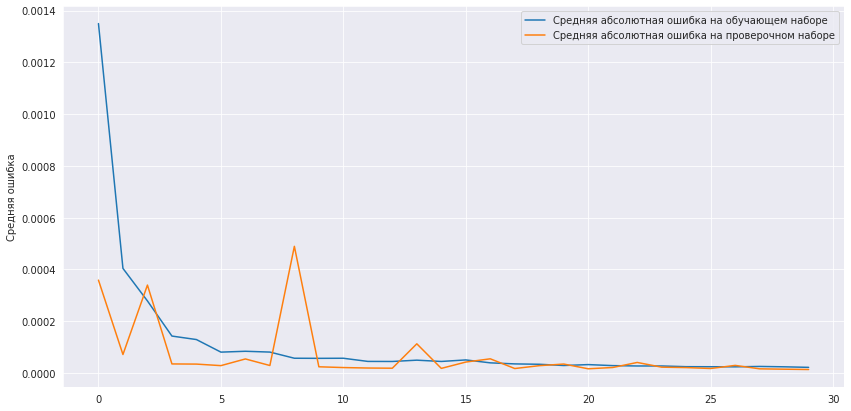

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history_10.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history_10.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

# пункт 3. Графики сравнения по 10 шагам

In [ ]:
currModel = model_10 
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler) 


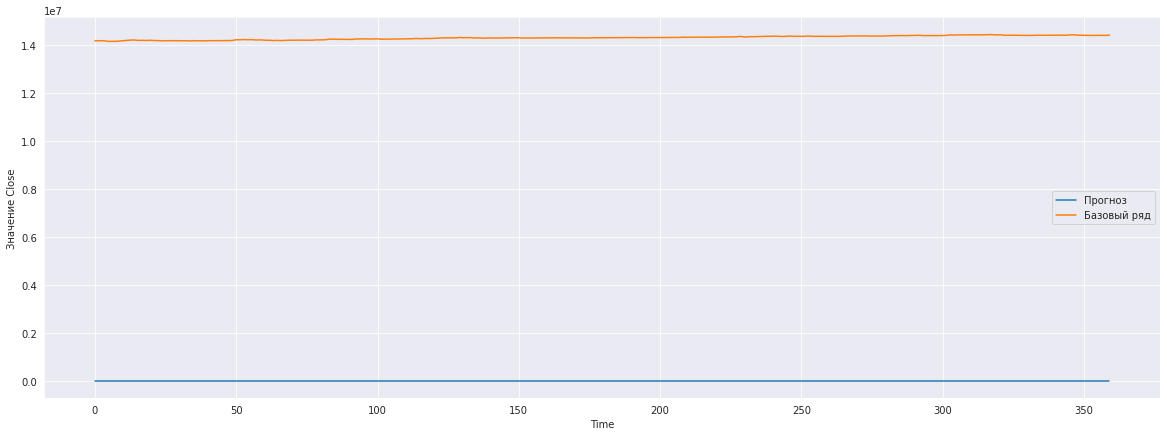

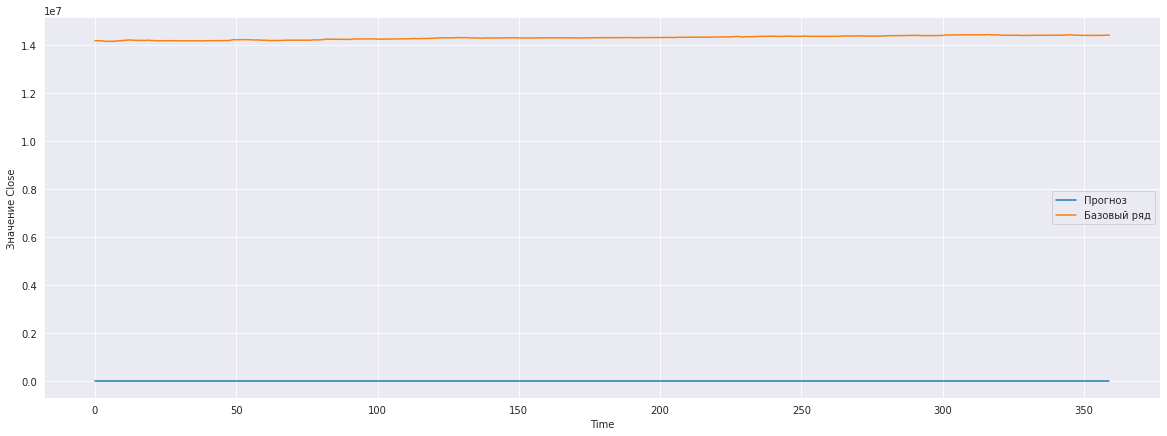

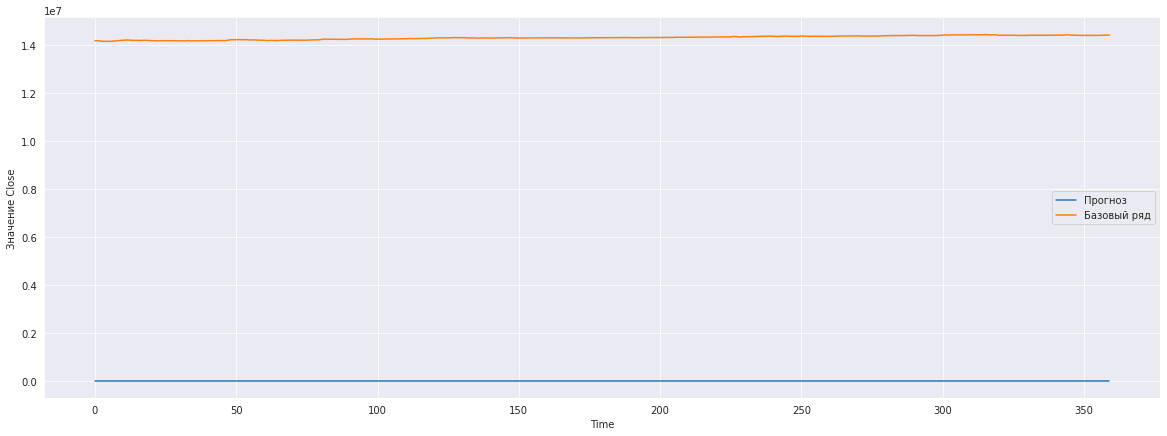

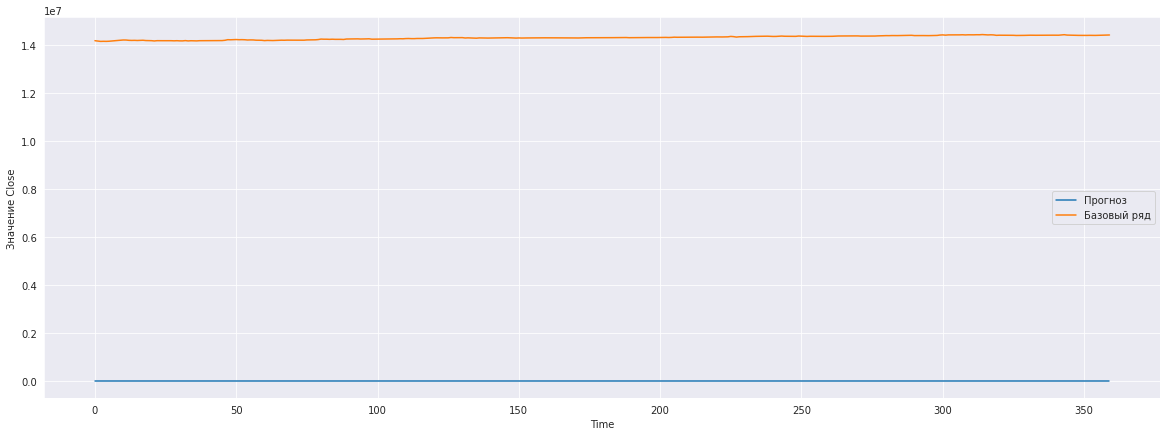

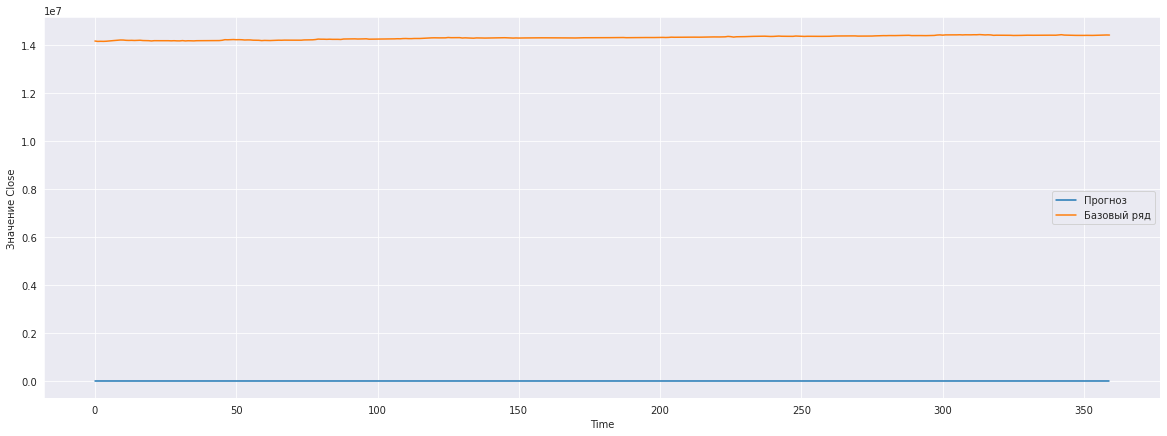

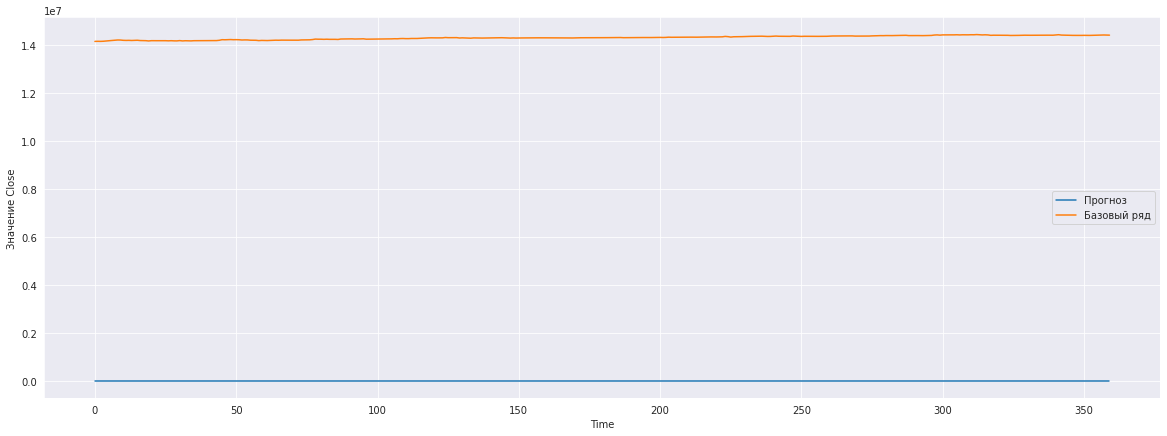

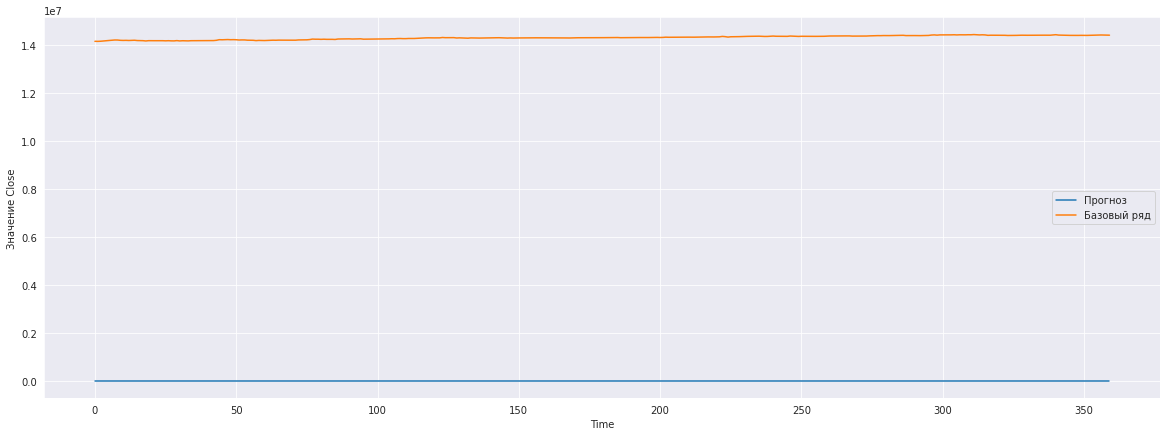

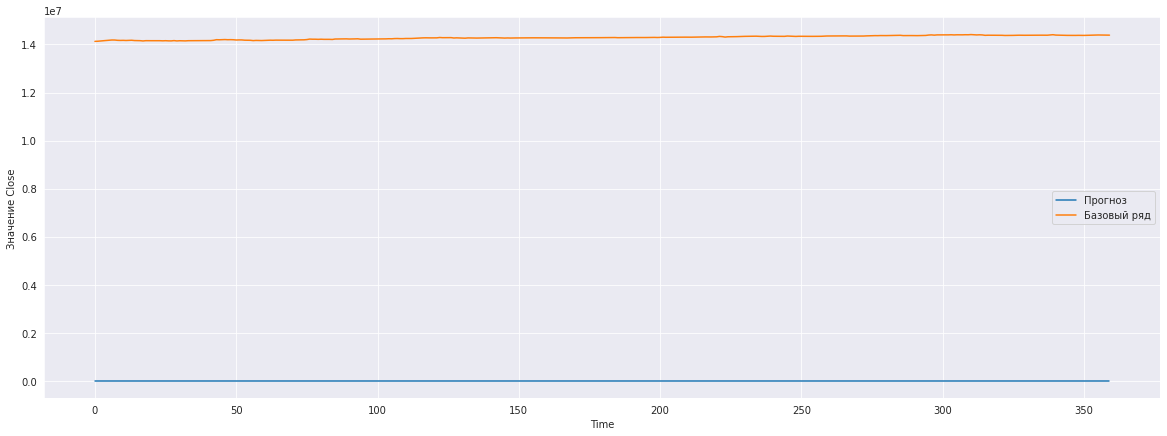

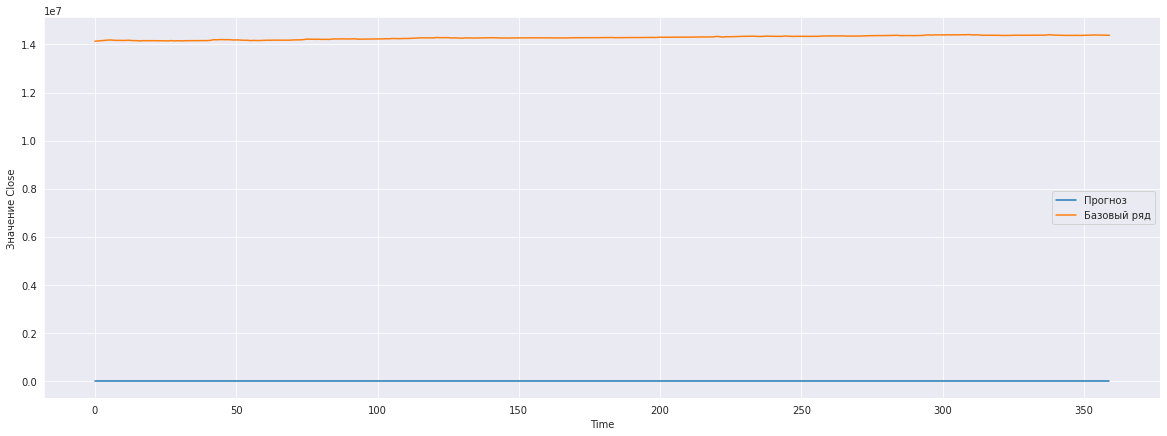

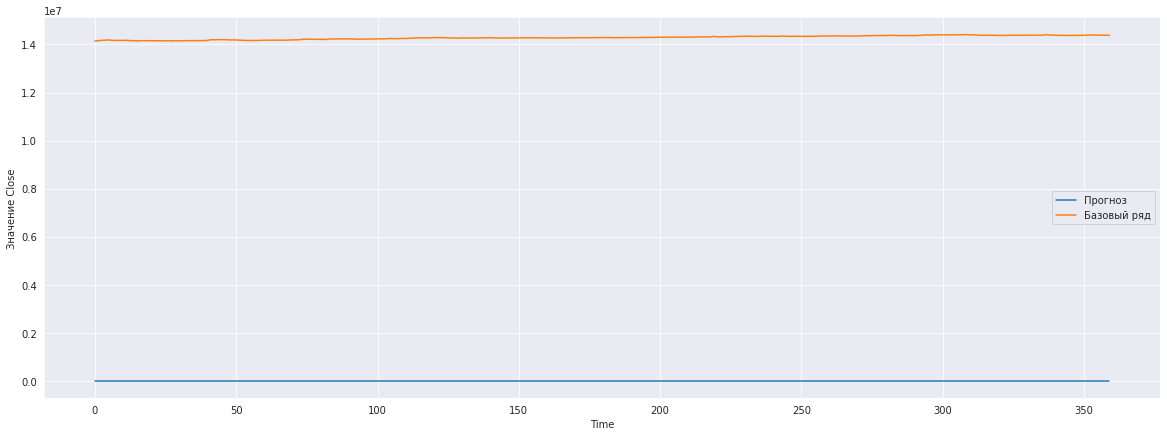

In [ ]:
for i in range(10):
  showPredict(0, 360, i, predVal, yValUnscaled)

# пункт 4. Слой Conv1D

In [ ]:
modelC = Sequential()

modelC.add(Conv1D(64, 5, input_shape = (xLen,5), activation="relu"))
modelC.add(Conv1D(32, 5, activation="relu"))
modelC.add(MaxPooling1D())
modelC.add(Flatten())
modelC.add(Dense(128, activation="relu"))
modelC.add(Dense(10, activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))
modelC.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 296, 64)           1664      
                                                                 
 conv1d_7 (Conv1D)           (None, 292, 32)           10272     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 146, 32)          0         
 1D)                                                             
                                                                 
 flatten_5 (Flatten)         (None, 4672)              0         
                                                                 
 dense_10 (Dense)            (None, 128)               598144    
                                                                 
 dense_11 (Dense)            (None, 10)                1290      
                                                      

In [ ]:
history_C = modelC.fit(trainDataGen, epochs=30, verbose=1, validation_data=testDataGen)

Epoch 1/30
4942/4942 [==============================] - 23s 3ms/step - loss: 5.0177e-04 - val_loss: 3.0917e-04
Epoch 2/30
4942/4942 [==============================] - 16s 3ms/step - loss: 1.9170e-04 - val_loss: 1.4892e-04
Epoch 3/30
4942/4942 [==============================] - 16s 3ms/step - loss: 1.3672e-04 - val_loss: 1.3540e-04
Epoch 4/30
4942/4942 [==============================] - 16s 3ms/step - loss: 1.1627e-04 - val_loss: 5.3057e-05
Epoch 5/30
4942/4942 [==============================] - 16s 3ms/step - loss: 9.0701e-05 - val_loss: 2.9975e-04
Epoch 6/30
4942/4942 [==============================] - 16s 3ms/step - loss: 7.1908e-05 - val_loss: 4.8629e-05
Epoch 7/30
4942/4942 [==============================] - 16s 3ms/step - loss: 7.6687e-05 - val_loss: 5.9891e-05
Epoch 8/30
4942/4942 [==============================] - 16s 3ms/step - loss: 6.4072e-05 - val_loss: 3.5285e-05
Epoch 9/30
4942/4942 [==============================] - 16s 3ms/step - loss: 6.3086e-05 - val_loss: 3.5595e-05
E

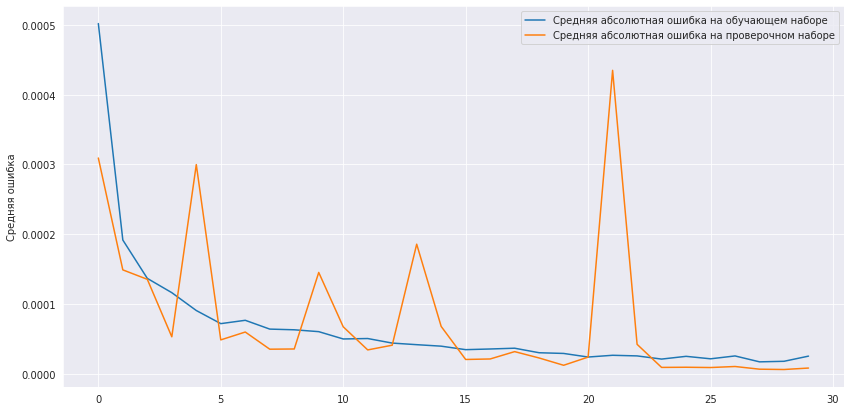

In [ ]:
plt.figure(figsize=(14,7))
plt.plot(history_C.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history_C.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

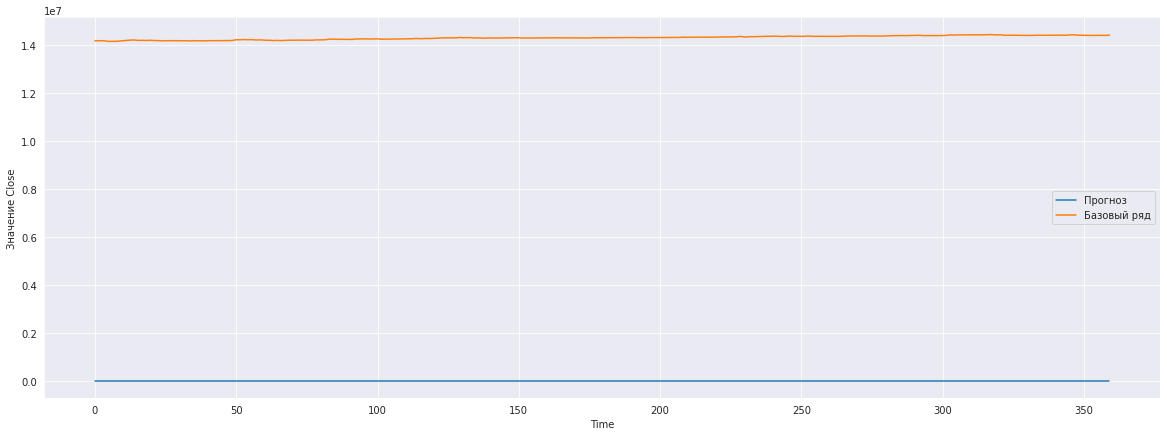

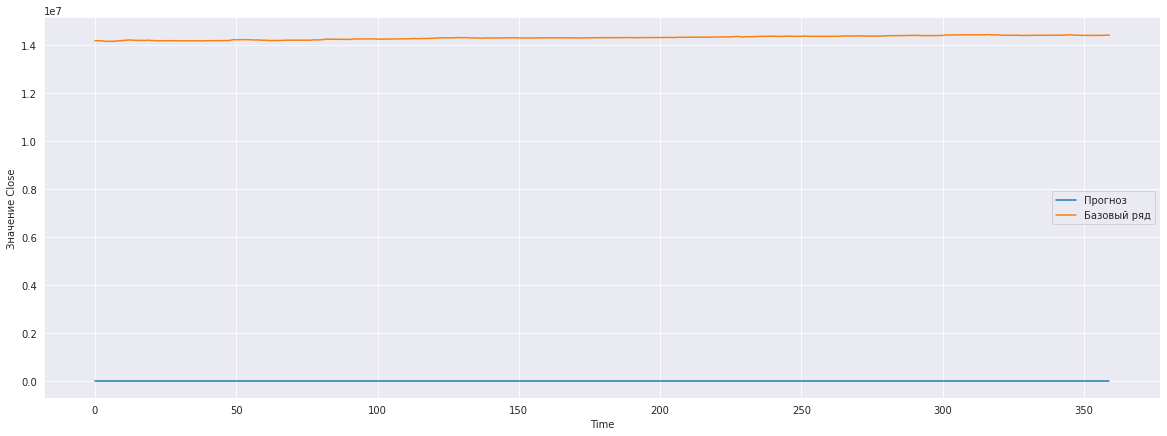

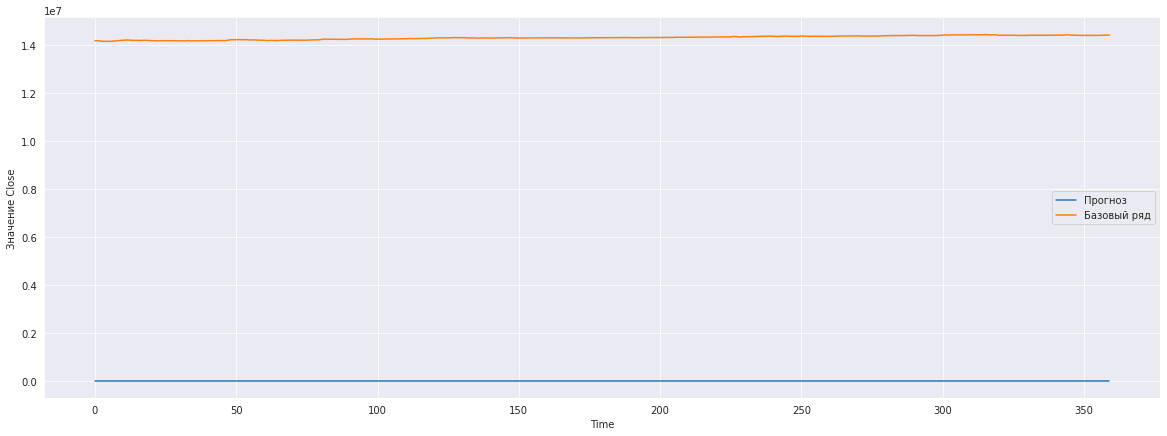

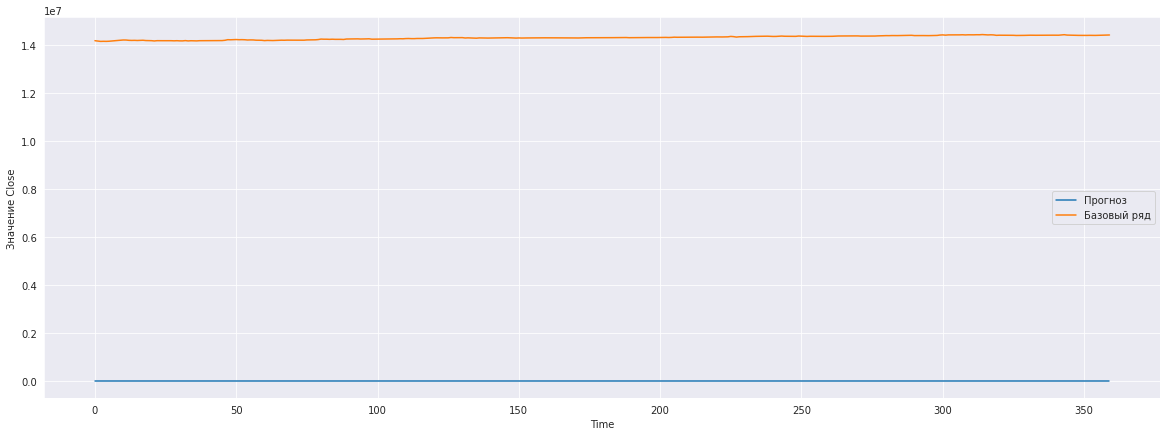

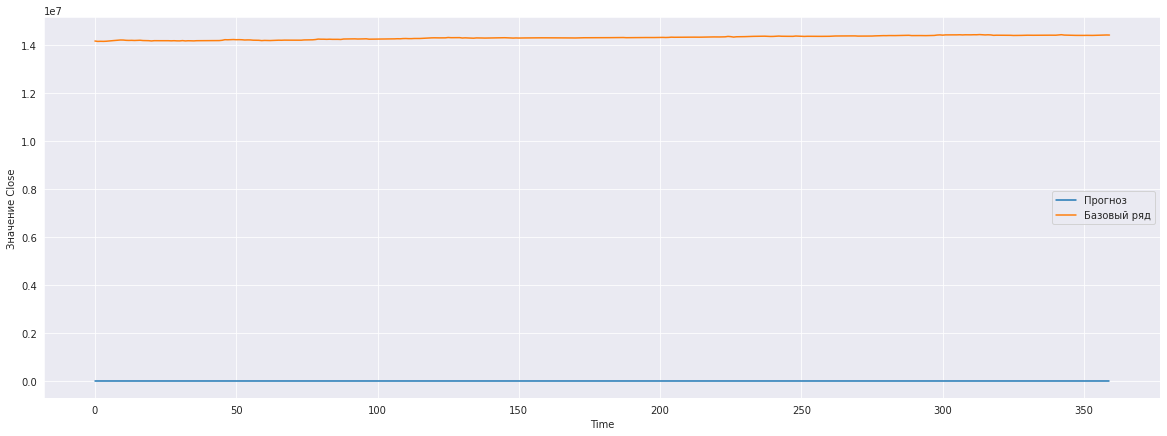

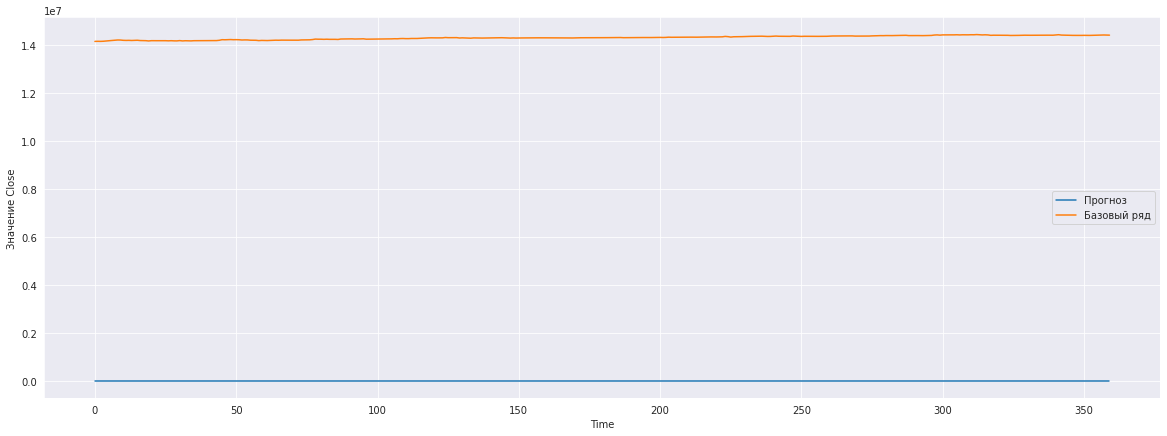

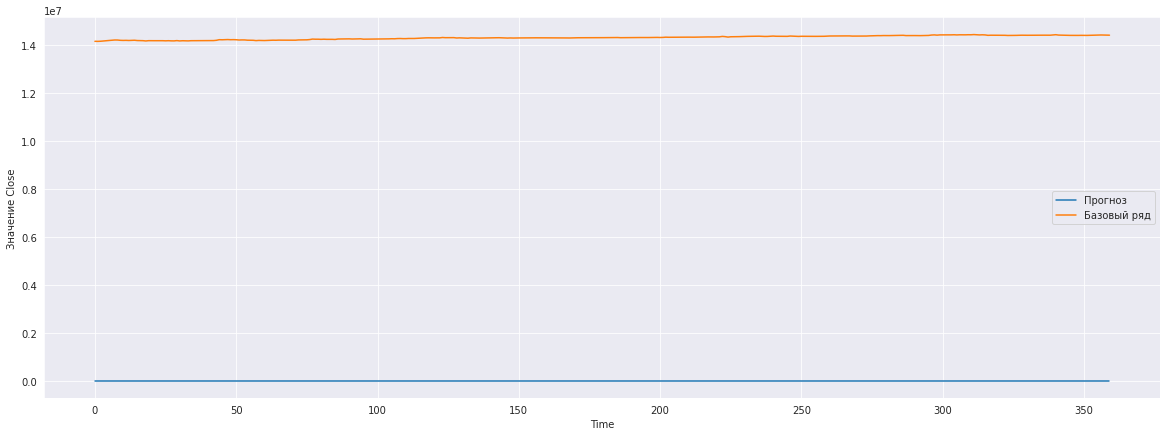

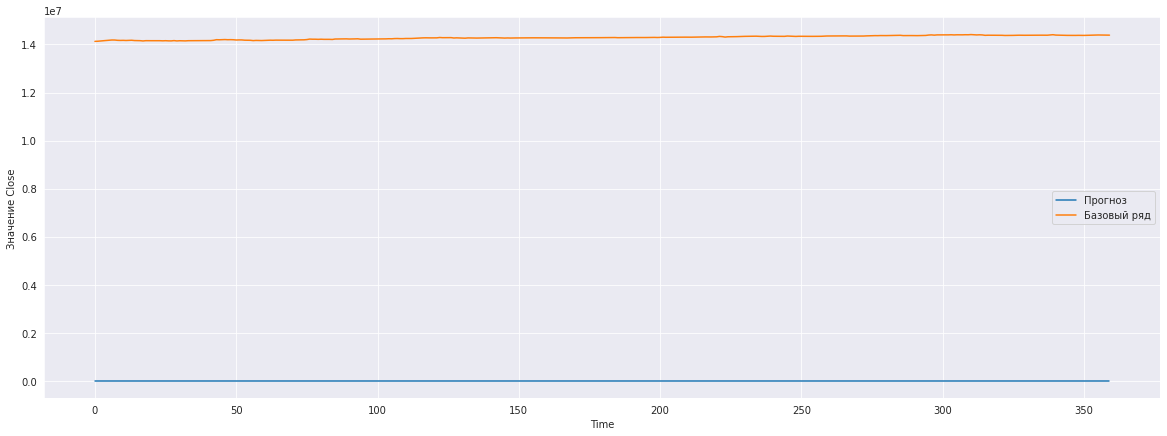

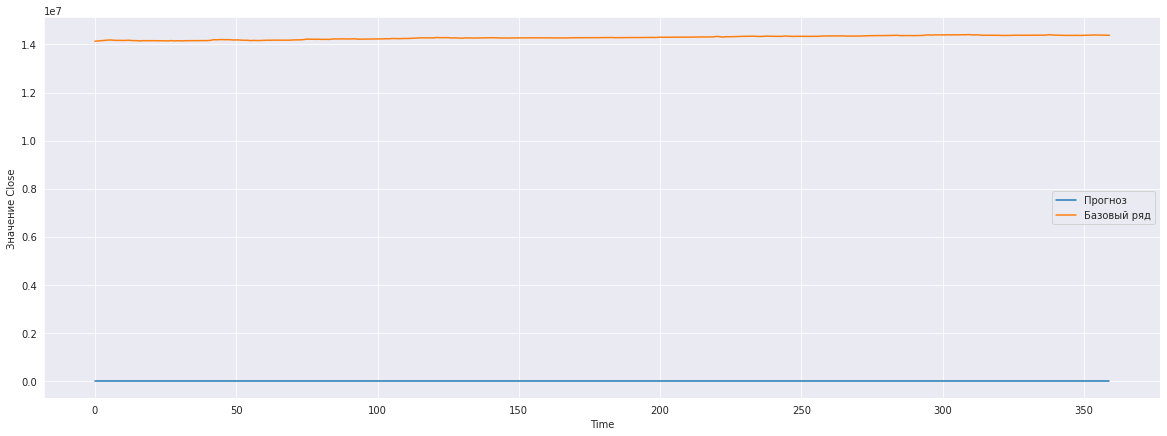

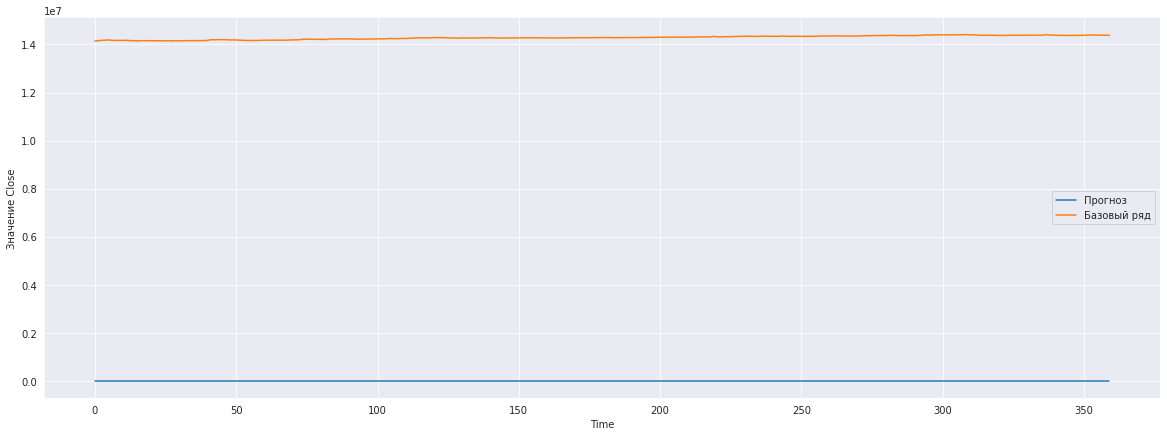

In [ ]:
currModel = modelC 
(predVal, yValUnscaled) = getPred(currModel, xVal[0], yVal[0], yScaler)
for i in range(10):
  showPredict(0, 360, i, predVal, yValUnscaled)

**Вывод:** Как я понимаю, простая как и другие повторяют предыдущие значения, но с 10 шагами предсказывает несколько лучше, чем с одним, а свёрточный слой результат улучшает. Но не меняет общей картины.